# Notes on floating point numbers

## The basics
Floating point numbers are represented in terms of a base $\beta$,
a precision $p$, and an exponent $e$. If $\beta=10$ and
$p=2$, then the number $0.034$ can be represented as $3.4\times 10^{-2}$.
With this representation, its exponent is $e=-2$. With this specification,
floating point numbers are not unique, as this same number can be represented
as $34\times 10^{-3}$ or $0.34\times 10^{-1}$. Thus, we typically take a 
floating point number to have the specific form
$$
\pm(d_0+d_1\beta^{-1}+\cdots+d_{p-1}\beta^{-(p-1)})\beta^e,
$$
where each $d_i$ is an integer in $[0,\beta)$ and $d_0\neq0$. Such a
representation is said to be a normalized floating point number.


Computers work more naturally in binary 
(or base 2) and most are hardwired this way. Thus, in the equation above, we have $\beta=2$ and each digit
$d_i$ is zero or one. Taking this into account, here are some easily representable numbers
with $p=5$ and $-5\leq e \leq 5$:

  * $8 = 1.0000 \times 2^3 = 1000_{\dot 2}0$
  * $\frac{1}{4} = 1.0000 \times 2^{-2} = 0_{\dot 2}01$
  * $\frac{5}{16} = 1.0100 \times 2^{-2} = 0_{\dot 2}0101$
  * $42 = 1.0101 \times 2^{5} = 101010_{\dot 2}$

## Distribution
It turns out that normalized floating point numbers are not distributed uniformly. Let's plot the binary floating point numbers with precision 4 and maximum exponent size 3.

In [1]:
# Define the parameters
digit_length = 4
exponent_size = 3

In [2]:
# Generate all binary tuples of length 4
from itertools import product
a = [range(2)]*digit_length
tuples = tuple(product(*a))
tuples

((0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1))

In [3]:
# All the numbers of the form 1.dddd
import numpy as np
bins = [2**(-n) for n in range(1,digit_length+1)]
lead_ones = [1+np.dot(tup, bins) for tup in tuples]
lead_ones

[1.0,
 1.0625,
 1.125,
 1.1875,
 1.25,
 1.3125,
 1.375,
 1.4375,
 1.5,
 1.5625,
 1.625,
 1.6875,
 1.75,
 1.8125,
 1.875,
 1.9375]

In [4]:
# Mulitply each of the above by 2**(-n) over -3<=n<=3
# Include the negatives as well.
bins = [2**(-n) for n in range(-exponent_size,exponent_size+1)]
shifty = product(lead_ones,bins)
def times(x,y): return x*y
positive_numbers = [times(*xy) for xy in shifty]
negative_numbers = [-x for x in positive_numbers]
numbers = positive_numbers + negative_numbers
len(numbers)

224

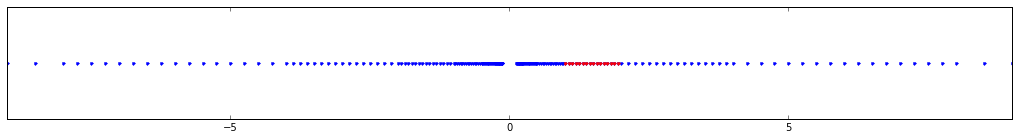

In [5]:
# Plot them!
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(numbers, np.zeros(len(numbers)),'.')
plt.plot(lead_ones, np.zeros(len(lead_ones)),'r.')
ax = plt.gca()
ax.set_yticks([])
ax.set_xlim(-9,9)
fig = plt.gcf()
fig.set_figwidth(18)
fig.set_figheight(2)
plt.savefig('floating_point_distribution.eps', bbox_inches='tight')

The numbers of the form $1.dddd$ (called `lead_ones` in the code) are shown in red. The other postive numbers have the form $2^nx$ for some $x$ with a leading 1. That leads to the scaling effect that we see.

Note, also, the hole near zero. That's because the smallest, postive, representable number (in this system) is $2^{-3}$. The next smallest is $(1+1/16)\times2^{-3}$ and the difference between these is quite a bit smaller than the smallest postive.

In [6]:
smallest = 2**(-3)
next_smallest = (1+1/16)*2**(-3)
[smallest, next_smallest-smallest]

[0.125, 0.0078125]

## 64 bit numbers
The IEEE standard for double precision floating point
numbers specifies that 64 bits be used to represent the number. Specifically,
it requires

  * $1$ bit for the sign $s$.
  * $11$ bits for the exponent $e$ giving a range of $2^{11} = 2048$ choices for
  the exponent, which is assumed to be between $-1023$ and $1024$.
  * $53$ bits for the significant or mantissa $c=1.d_1d_2\cdots d_{52}$. 

Since the leading digit must be a $1$, we only need to store 52 digits.
Given those choices for $s$, $e$, and $c$, our number is 
$$(-1)^s\times c \times \beta^e.$$
Since the exponent $e$ is expressed in binary with no sign, it might be more natural to think of it in the range $0\leq e < 2048$. In this case, we might write the number
$$(-1)^s\times c \times \beta^{e-1023}.$$
Note that the standard leaves quite a bit freedom allowing differences and optimizations between implementations. Often, a few strings are reserved for special numbers or, more often, there are a few extra bits included.

As an example, suppose we'd like to compute the number with bit string
$$1\,\,10100000000000000000000000000000000000000000000000101\,\,10100000101$$
We might do the following:

In [7]:
dd = np.zeros(52, dtype=int)
dd[0]=dd[-1]=dd[2]=dd[-3]=1
ee = np.zeros(11, dtype=int)
ee[0]=ee[2]=ee[-1]=ee[-3]=1
s=1
bins = [2**(-n) for n in range(1,53)]
c = 1+np.dot(dd,bins)
bins2 = [2**(n) for n in range(11)]
e = int(np.dot(ee,bins2)-1023)
number_from_bin = (-1)**s * c * 2**e
number_from_bin

-1.2042377280680893e+79

In [8]:
e

262

In [9]:
dd = np.zeros(52, dtype=int)
dd[0]=dd[-1]=dd[2]=dd[-3]=1
bins = [2**(-n) for n in range(1,53)]
c = 1+np.dot(dd,bins)
c

1.6250000000000011

## Exploring numbers with Python
Python provides some nice tools to explore numbers and their expansions. 
`sys.float_info` stores information on how floating point numbers are stored
on your machine.

In [10]:
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

The full exponent range isn't quite used because some configurations represent special numbers, like 0 and `NaN`. If someone wants to explain this to me, that'd be awesome.

In [11]:
2**(-1022)

2.2250738585072014e-308

It ougtta be in section 5.2.4.2.2 of [the C standard](http://www.open-std.org/jtc1/sc22/wg14/www/docs/n1256.pdf) somewhere.

To get the largest possible value, at least, we take each digit to be $d_k=1$ and
the exponent to be $e=1024$.

In [12]:
s = sum([2**(-k) for k in range(1,54)])
for i in range(1024):
    s = 2*s
s

1.7976931348623157e+308

Another useful tool is `float.hex`, which displays the hexadecimal expansion
of a number.

In [13]:
float.hex(0.1)

'0x1.999999999999ap-4'

This indicates that the internal representation of $0.1$ is
$$2^{-4}\left(1+\sum_{k=1}^{12} \frac{9}{16^k} + \frac{10}{16^{13}}\right) \approx 
0.10000000000000000555.$$

We can use this information to fully understand the discrepancy between
$(0.1+0.2)+0.3$ and $0.1+(0.2+0.3)$.
Not surprisingly, the hexadecimal representation of $0.2$ is 
`0x1.999999999999ap-3`.
The hexadecimal representation of $0.3$ is `0x1.3333333333333p-2`,
which to 17 digits is $0.29999999999999999$ or exactly $0.3$ when rounded. The sum of
these three numbers yields $0.6000000000000001$, which is slightly larger than 
the desired value of $0.6$. By contrast, the computer's computation of
$0.2+0.3$ yields *exactly* $0.5$, which is not surprising since $0.5$
easily representable in binary. Then, $0.1+0.5$ yields exactly the computer
representation of $0.6$ after rounding.

We can also use this to double check our `number_from_bin`.

In [14]:
point_1 = (1+sum([9/16**k for k in range(1,13)]) + 10/16**13)*2**(-4)
point_1

0.1

In [15]:
float.hex(number_from_bin)

'-0x1.a000000000005p+262'

## An application - long summation

Suppose we want to estimate the harmonic number
$$\sum_{k=1}^{n} \frac{1}{k}$$
for $n=1000$. It turns out that the order matters.

In [16]:
terms = [1/k for k in range(1,1001)]
sum1 = sum(terms)
terms.reverse()
sum2 = sum(terms)
sum1-sum2

2.6645352591003757e-15

The estimates might appear to be close but their difference is 10 times larger than machine epsilon. Which is better?

When we add two machine numbers $a$ and $b$, the result $\text{fl}(a+b)$ generally looks like
$$\text{fl}(a+b) = (a+b)(1+\varepsilon).$$
We might think of $\varepsilon$ as a psuedo-random number between zero and machine epsilon. The point is, due to the distribution of machine numbers, the potential size of the error is proportional to the actual value of the sum.

Now, if we add three numbers together, we get
$$\text{fl}(\text{fl}(a+b)+c) = ((a+b)(1+\varepsilon)+c)(1+\varepsilon) = (a+b+c) + (2a+2b+c)\varepsilon +O(\varepsilon^2).$$
Note that the numbers that are added first contribute twice to the error. Thus, we have less error, if we add the smaller numbers first. The problem is compounded if we add four numbers:
$$\text{fl}(\text{fl}(\text{fl}(a+b)+c)+d) = (a+b+c+d)+(3 a+3 b+2 c+d) \varepsilon + O(\varepsilon^2).$$